<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/salzcamino/handson-ml3/blob/main/practice/Chapter03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

In [4]:
X,y = mnist.data, mnist.target

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
# Reshape feature vector to 28x28 array for display purposes
import matplotlib.pyplot as plt
def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap = "binary")
  plt.axis("off")

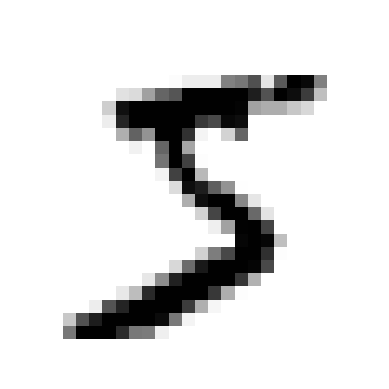

In [8]:
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [9]:
y[0]

'5'

In [10]:
# Split the test and train data
# These are pre-shuffled in this dataset
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a binary classifier
Using only the 5 digit

In [11]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
# Trying a dummy classifier to see if our model is really that good
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
dummy_clf.predict(X_train)
print(any(dummy_clf.predict(X_train)))
cross_val_score(dummy_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

False


array([0.90965, 0.90965, 0.90965])

In [16]:
# Implemeting our own cross validation function
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def skFolds(n_splits, classifier):
  skfolds = StratifiedKFold(n_splits = n_splits)

  for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(classifier)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

In [17]:
skFolds(n_splits = 3, classifier = sgd_clf)

0.95035
0.96035
0.9604


In [18]:
# Using cross validation predictions to construct a confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [20]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred) # when it predicts a 5, how often is it correct?
recall = recall_score(y_train_5, y_train_pred) # how many of the 5s does it correctly classify?
print(precision, recall)

0.8370879772350012 0.6511713705958311


In [21]:
from sklearn.metrics import f1_score # TP / (TP + (FN + FP)/2)
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [22]:
# Exploring the decision function
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
# Exploring how to set the threshold value
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

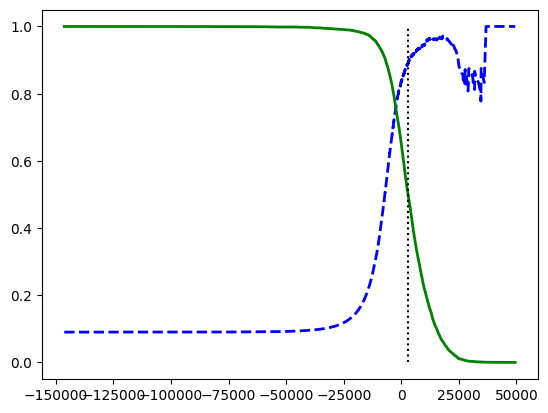

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

In [27]:
# Finding the lowest threshold to give 90% precision
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [28]:
# To make predictions with this threshold
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

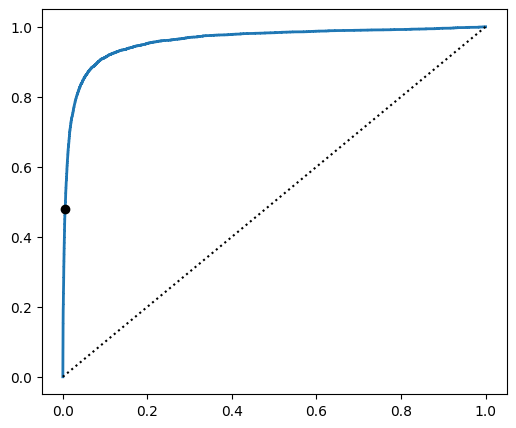

In [31]:
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [33]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [34]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [35]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

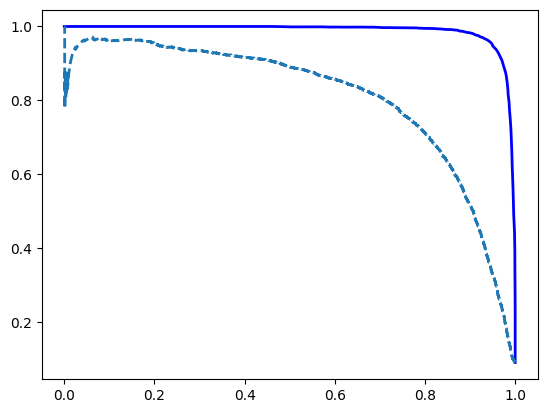

In [36]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

In [37]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [39]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [40]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

In [41]:
# Multiclass classification
# One vs Rest classification
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

SVC(random_state=42)

In [42]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [43]:
some_digit_scores = svm_clf.decision_function([some_digit]) # viewing prediction scores
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [44]:
class_id = some_digit_scores.argmax()
svm_clf.classes_
svm_clf.classes_[class_id]

'5'

In [45]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [46]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [47]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [48]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

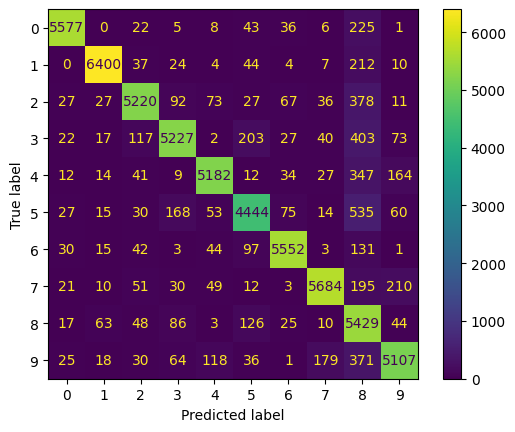

In [51]:
# Error Analysis
from sklearn.metrics import ConfusionMatrixDisplay
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

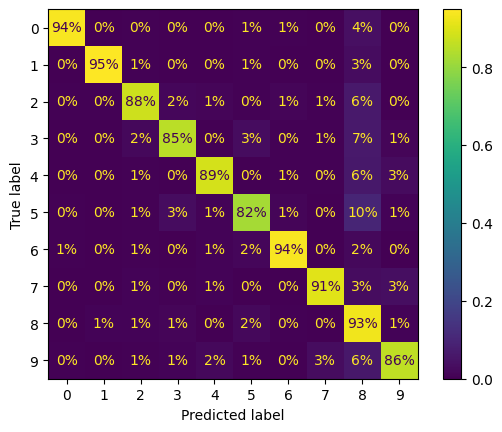

In [52]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

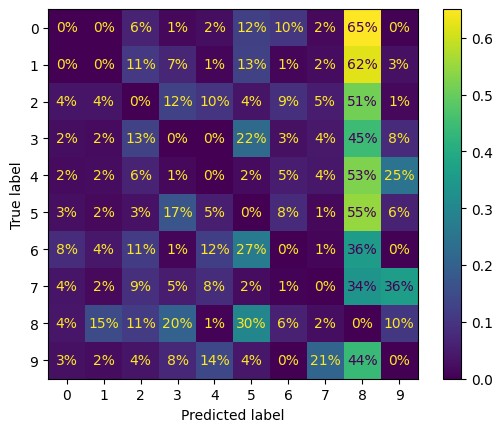

In [53]:
# Set correct predictions to zero so that we can see the percentage of errors for each misclassification
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")
plt.show()

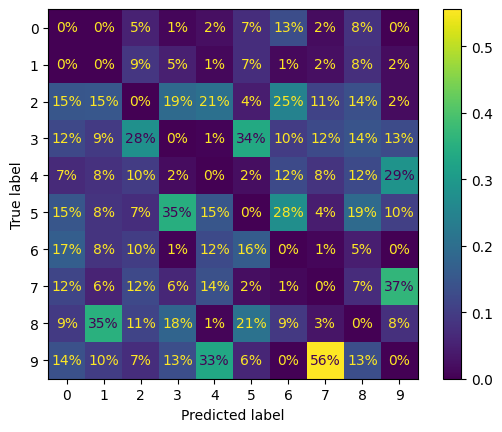

In [54]:
# Normalizing by prediction (columns)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%")
plt.show()

In [55]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

Text(0, 0.5, 'True label')

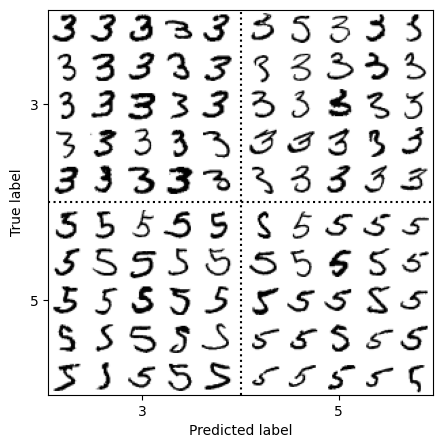

In [56]:
# Plot images of 3 and 5 in confusion matrix shape
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")

In [57]:
# Multilabel classification
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [58]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [59]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [60]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

In [61]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [62]:
chain_clf.predict([some_digit])

array([[0., 1.]])

In [65]:
# Multiout classifier
np.random.seed(42) # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

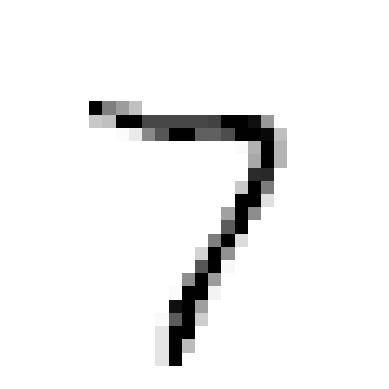

In [66]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()


Exercises
---



In [78]:
""" 1. Try to build a classifier for the MNIST dataset that achieves over 97%
accuracy on the test set. Hint: the KNeighborsClassifier works quite
well for this task; you just need to find good hyperparameter values
(try a grid search on the weights and n_neighbors hyperparameters)."""
from sklearn.model_selection import GridSearchCV
knn_clf = KNeighborsClassifier()

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ....n_neighbors=3, weights=uniform;, score=0.969 total time= 1.1min
[CV 2/3] END ....n_neighbors=3, weights=uniform;, score=0.968 total time= 1.0min
[CV 3/3] END ....n_neighbors=3, weights=uniform;, score=0.968 total time= 1.0min
[CV 1/3] END ...n_neighbors=3, weights=distance;, score=0.970 total time= 1.0min
[CV 2/3] END ...n_neighbors=3, weights=distance;, score=0.969 total time= 1.0min
[CV 3/3] END ...n_neighbors=3, weights=distance;, score=0.969 total time= 1.0min
[CV 1/3] END ....n_neighbors=4, weights=uniform;, score=0.966 total time= 1.0min
[CV 2/3] END ....n_neighbors=4, weights=uniform;, score=0.966 total time= 1.0min
[CV 3/3] END ....n_neighbors=4, weights=uniform;, score=0.967 total time= 1.0min
[CV 1/3] END ...n_neighbors=4, weights=distance;, score=0.971 total time= 1.0min
[CV 2/3] END ...n_neighbors=4, weights=distance;, score=0.970 total time= 1.0min
[CV 3/3] END ...n_neighbors=4, weights=distance;,

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [79]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [80]:
cross_val_score(knn_clf, X_train, y_train, cv = 3, scoring = "accuracy")


array([0.9676 , 0.9671 , 0.96755])

In [83]:
grid_search.best_estimator_.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [84]:
grid_search.score(X_test, y_test)

0.9714

In [187]:
""" 2. Write a function that can shift an MNIST image in any direction (left,
right, up, or down) by one pixel.⁠ Then, for each image in the training
set, create four shifted copies (one per direction) and add them to the
training set. Finally, train your best model on this expanded training set
and measure its accuracy on the test set. You should observe that your
model performs even better now! This technique of artificially
growing the training set is called data augmentation or training set
expansion. """
from scipy.ndimage import shift
def shift_image(image, dx, dy):
  image_reshape = image.reshape(28,28)
  image_shift = shift(image_reshape, [dy, dx])
  return(image_shift.reshape([-1]))

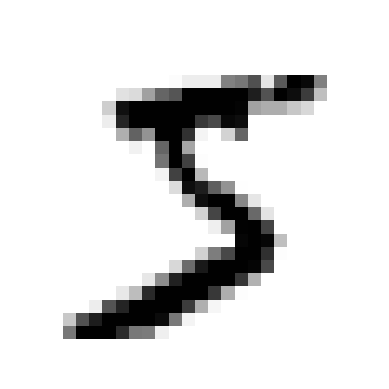

In [188]:
plot_digit(some_digit)

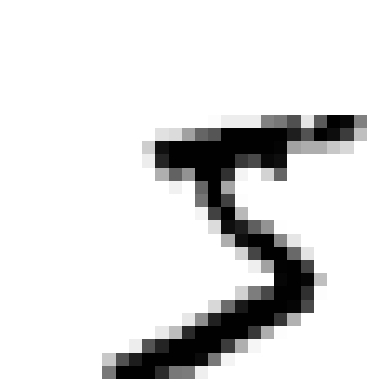

In [189]:
plot_digit(shift_image(some_digit, 3, 3))

In [208]:
def create_shifted_copies(image):
  shifted_images = []
  for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_image = shift_image(image, dx, dy)
    shifted_images.append(shifted_image)
  return shifted_images

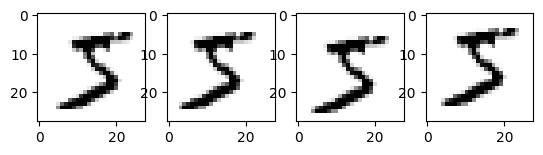

In [220]:
new_images = create_shifted_copies(some_digit)
plt.subplot(141)
plt.imshow(new_images[0].reshape(28,28), cmap = "Greys")
plt.subplot(142)
plt.imshow(new_images[1].reshape(28,28), cmap = "Greys")
plt.subplot(143)
plt.imshow(new_images[2].reshape(28,28), cmap = "Greys")
plt.subplot(144)
plt.imshow(new_images[3].reshape(28,28), cmap = "Greys")
plt.show()

In [229]:
def augment_shifted_copies(X_set, y_set):
  X_augmented = X_set
  y_augmented = y_set
  for image, label in zip(X_set,y_set):
    print(image)
  return X_augmented, y_augmented

In [239]:
augment_shifted_copies(X_train[1], y_train[1])

0


(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51, 159, 253,
        159,  50,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 238,
        252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [193]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [238]:
X_train_subset = X_train[1:2]
y_train_subset = y_train[0:1]
for image in X_train_subset:
  print(image)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 163 252 252 252 253 252 252  96 189 253 167   

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17